In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.drop('Name', axis=1)


In [2]:
# Identify missing days 
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_days = all_days.difference(data.index)

missing_days_df = pd.DataFrame(missing_days, columns=['MissingDate'])
missing_days_df['DayOfWeek'] = missing_days_df['MissingDate'].dt.day_name()

print("Missing days with day of the week:")
print(missing_days_df)

pattern_analysis = missing_days_df['DayOfWeek'].value_counts()
print("\nPattern of missing days by day of the week:")
print(pattern_analysis)

Missing days with day of the week:
     MissingDate DayOfWeek
0     2006-01-07  Saturday
1     2006-01-08    Sunday
2     2006-01-14  Saturday
3     2006-01-15    Sunday
4     2006-01-16    Monday
...          ...       ...
1354  2017-12-16  Saturday
1355  2017-12-17    Sunday
1356  2017-12-23  Saturday
1357  2017-12-24    Sunday
1358  2017-12-25    Monday

[1359 rows x 2 columns]

Pattern of missing days by day of the week:
DayOfWeek
Saturday     625
Sunday       625
Monday        59
Friday        21
Thursday      17
Tuesday        8
Wednesday      4
Name: count, dtype: int64


In [3]:
# NaN values
data[data.isna().any(axis=1)]

,Open,High,Low,Close,Volume
Date,,,,,
2017-07-31,NaN,144.93,NaN,144.67,4355718


In [4]:
# cleanup
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')

# RNN

In [ ]:
# Use only the 'Close' column for this example
close_prices = data_resampled['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices)

# Prepare the dataset for RNN
T = 7  
X, Y = [], []
for t in range(len(close_prices_scaled) - T):
    X.append(close_prices_scaled[t:t + T])
    Y.append(close_prices_scaled[t + T])

X = np.array(X)
Y = np.array(Y)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (4372, 7, 1) Y.shape (4372, 1)


In [6]:
# Split into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

In [8]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='tanh', input_shape=(T, 1)))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Predict on the test set
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and true values
Y_pred = scaler.inverse_transform(Y_pred_scaled)
Y_test = scaler.inverse_transform(Y_test)


Epoch 1/50
110/110 [==============================] - 3s 10ms/step - loss: 0.0343 - val_loss: 0.0013
Epoch 2/50
110/110 [==============================] - 1s 6ms/step - loss: 8.5226e-04 - val_loss: 6.2173e-04
Epoch 3/50
110/110 [==============================] - 1s 6ms/step - loss: 4.6656e-04 - val_loss: 3.2550e-04
Epoch 4/50
110/110 [==============================] - 1s 6ms/step - loss: 3.4454e-04 - val_loss: 4.6212e-04
Epoch 5/50
110/110 [==============================] - 1s 6ms/step - loss: 2.9563e-04 - val_loss: 2.8245e-04
Epoch 6/50
110/110 [==============================] - 1s 8ms/step - loss: 2.8952e-04 - val_loss: 2.3421e-04
Epoch 7/50
110/110 [==============================] - 1s 7ms/step - loss: 2.7194e-04 - val_loss: 2.7107e-04
Epoch 8/50
110/110 [==============================] - 1s 8ms/step - loss: 2.8894e-04 - val_loss: 2.4581e-04
Epoch 9/50
110/110 [==============================] - 1s 8ms/step - loss: 2.6940e-04 - val_loss: 2.8092e-04
Epoch 10/50
110/110 [==============

Mean Squared Error on Test Set: 2.2404


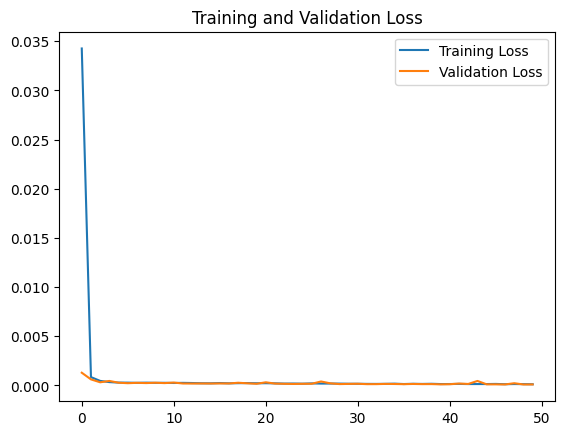

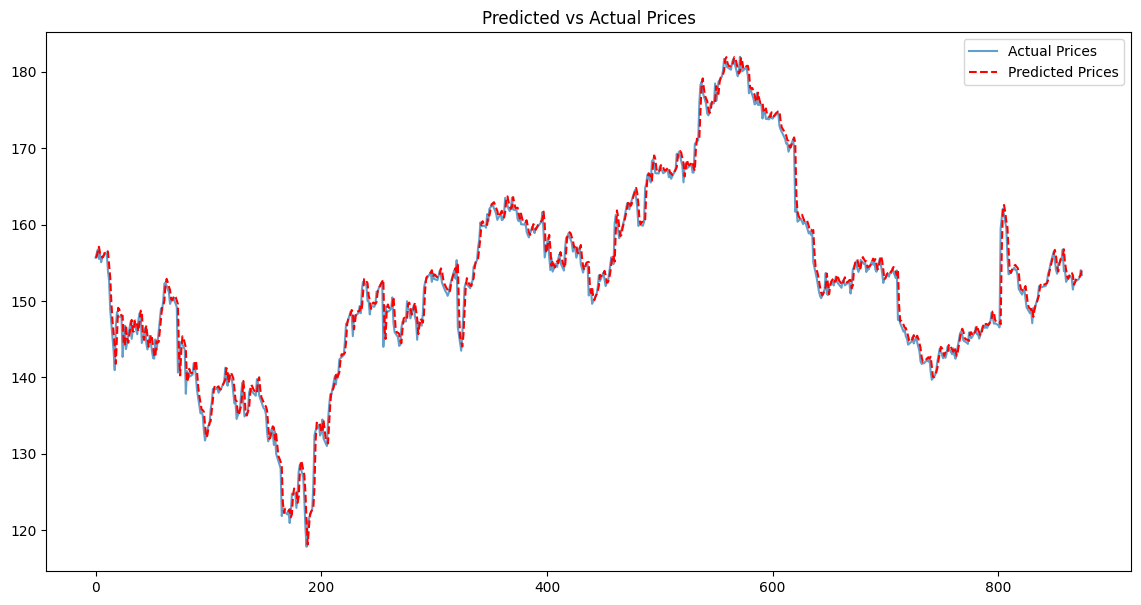

In [9]:
# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(Y_test, label='Actual Prices', alpha=0.7)
plt.plot(Y_pred, label='Predicted Prices', linestyle='--', color='red')
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()